In [1]:
#importing all the modules
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Exploratory Data Analysis & Data Cleaning

In this first section, the data will be imported, explored and cleaned in order to start approaching the subsequent prediction problems. It is very important here to get a full understanding of the data structure and quality. In this case, a historical dataset regarding hurricanes in the atlantic will be the analysed one. 

### 1.1. Data Structure

In [2]:
#Read the atlantic dataset
data = pd.read_csv('data/atlantic.csv')

In [3]:
#display first 5 rows
data.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [4]:
#display last 5 rows since the first columns of the dataset are not a really good indicator qualitywise.
data.tail(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0
49104,AL122015,KATE,20151113,1200,,EX,40.7N,45.4W,45,987,...,150,220,0,0,0,0,0,0,0,0


In [5]:
#check the data shape 
data.shape

(49105, 22)

The dataset is composed by 49105 rows (records) and 22 columns (attributes).

In [6]:
#check all data types of the dataset & its info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  int64 
 17  Moderate Win

With a very general notion of the data structure, it is time to start with the cleaning. At first, duplicate and null values must be erased. Secondly, a reestructuration of the fields will be carred out (formatting, data types & structure). 

In [7]:
# Checking and eliminating duplicate values
duplicate_rows = data[data.duplicated()]
print("Duplicate rows : ", duplicate_rows.shape)

Duplicate rows :  (0, 22)


As shown in this previous output, there are no duplicate rows in our dataset (0 refers to rows and 22 refers to the number of attributes int the dataset). Subsequently, missing values will be checked and dropped.

In [8]:
#Checking and dropping missing values
print(data.isnull().sum())

ID                  0
Name                0
Date                0
Time                0
Event               0
Status              0
Latitude            0
Longitude           0
Maximum Wind        0
Minimum Pressure    0
Low Wind NE         0
Low Wind SE         0
Low Wind SW         0
Low Wind NW         0
Moderate Wind NE    0
Moderate Wind SE    0
Moderate Wind SW    0
Moderate Wind NW    0
High Wind NE        0
High Wind SE        0
High Wind SW        0
High Wind NW        0
dtype: int64


As also shown in this previous output, there are no null values on any of the dataset columns and records.


### 1.2. Outliers Detection and Data Formatting
At this point, it is time to detect outliers in the data and delete its anomalies. Obviously, the outliers are only present in the continuous variables of the dataset. For this case, the main outliers to be detected will be in Longitude, Latitude, Max.Wind and Min.Pressure. Additionally, these must be reformatted: time and date (creating a timestamp column), lat and long will be normalized (only numerical and without the letter), and the rest of the wind values (low, moderate and high) will also be accordingly formatted(e.g. 0 instead of 999).

#### Latitude and Longitude outliers
For these two attributes, first we must format the data as fully numerical, by taking out the N/S/E/W and adding a plus or a minus instead depending on its geographical location. Once this is done (new fields as normalized lat and normalized long), the outliers analysis can be carried out.

In [9]:
#Fixing latitude and longitude in order to be mapped

#arrays to store the mapping lat and long values which will be added to the dataset
map_long = []
map_lat = []

for i in data['Latitude']:
    if i.endswith('N'):
        new_lat_n = i.replace('N', '')
        lat_float_n = float(new_lat_n)
        map_lat.append(lat_float_n)
    else:
        #for the Southern hemisphere (which must be negative)
        new_lat_s = i.replace('S', '')
        lat_float_s = float(new_lat)
        lat_south = lat_float_s * -1 
        map_lat.append(lat_south)
        

#same procedure but for longitude
for i in data['Longitude']:
    if i.endswith('E'): #East is positive
        new_lon_e = i.replace('E', '')
        lon_float_e = float(new_lon_e)
        map_long.append(lon_float_e)
    else:
        #for the Western hemisphere (which must be negative)
        new_lon_w = i.replace('W', '')
        lon_float_w = float(new_lon_w)
        lat_west = lon_float_w * -1 
        map_long.append(lat_west)

In [10]:
#We must append the two processed arrays to the Atlantic dataset
data['Normal Latitude'] = map_lat
data['Normal Longitude'] = map_long

In [11]:
data.head(10)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Normal Latitude,Normal Longitude
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-94.8
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-95.4
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-96.0
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.1,-96.5
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.2,-96.8
5,AL011851,UNNAMED,18510626,0,,HU,28.2N,97.0W,70,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.2,-97.0
6,AL011851,UNNAMED,18510626,600,,TS,28.3N,97.6W,60,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.3,-97.6
7,AL011851,UNNAMED,18510626,1200,,TS,28.4N,98.3W,60,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.4,-98.3
8,AL011851,UNNAMED,18510626,1800,,TS,28.6N,98.9W,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.6,-98.9
9,AL011851,UNNAMED,18510627,0,,TS,29.0N,99.4W,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,29.0,-99.4


Latitude max. value:  81.0
Latitude min. value:  7.2


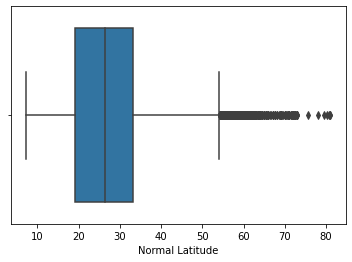

In [12]:
#Latitude outliers
lat_column = data['Normal Latitude']
sns.boxplot(x=lat_column)
print('Latitude max. value: ', lat_column.max())
print('Latitude min. value: ', lat_column.min())

As the latitude results show above, there are no anomal outliers on this attribute.

Longitude max. value:  63.0
Longitude min. value:  -359.1


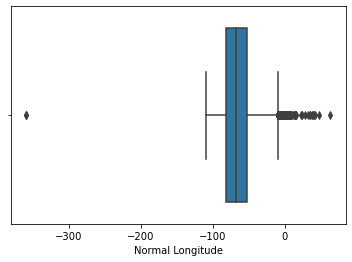

In [13]:
#Longitude outliers
long_column = data['Normal Longitude']
sns.boxplot(x= long_column)
print('Longitude max. value: ', long_column.max())
print('Longitude min. value: ', long_column.min())

In [14]:
#Longitude anomal outliers
#Longitude values which are smaller than -300 as shown in the boxplot, are clear error values
anomal_long = data[(data['Normal Longitude'] < - 300)]
anomal_long

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Normal Latitude,Normal Longitude
22984,AL051952,UNNAMED,19520914,600,,EX,43.2N,359.1W,35,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,43.2,-359.1
22985,AL051952,UNNAMED,19520914,1200,,EX,44.0N,358.4W,35,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,44.0,-358.4


In [15]:
#removal of the two anomal records
data = data[(data['Normal Longitude'] > - 300)]
data.shape

(49103, 24)

#### Min.Pressure and Max.Wind outliers

According to the metadata of this dataset (the dataset description), the missing values for Minimum Pressure are marked with -999 and the missing values for Maximum wind as -99. Therefore, we first identify these rows. 

In [16]:
anomal_min_pressure = data[(data['Minimum Pressure'] == -999)]
anomal_maxwind = data[(data['Maximum Wind'] == -99)]
print('Anomal Minimum Pressure records: ', anomal_min_pressure.shape)
print('Anomal Maximum Wind records: ', anomal_maxwind.shape)

Anomal Minimum Pressure records:  (30667, 24)
Anomal Maximum Wind records:  (338, 24)


According to these results, the Minimum Pressure column has way too many missing records and therefore, this column is not anymore valid for this analysis. According to this, this attribute must be deleted. 
Regarding the Maximum Wind, since there much less values missing, these will be replaced by the median values of the entire column